[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEPE-USD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (5m 2024-11-01 -> 2024-11-30)')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing 8298 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8298,)


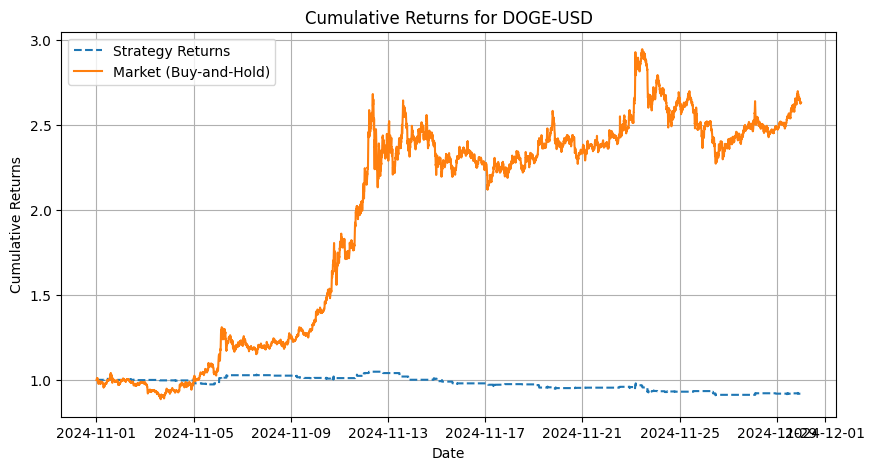

Processing 0 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (0,)


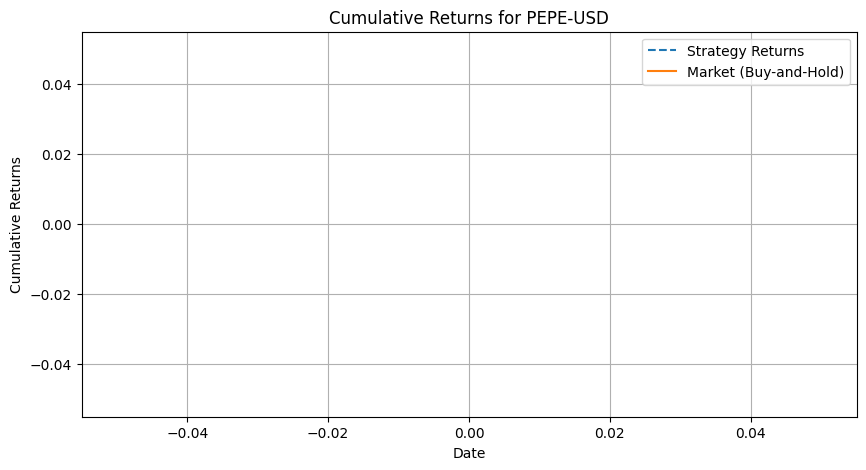

Processing 8348 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8348,)


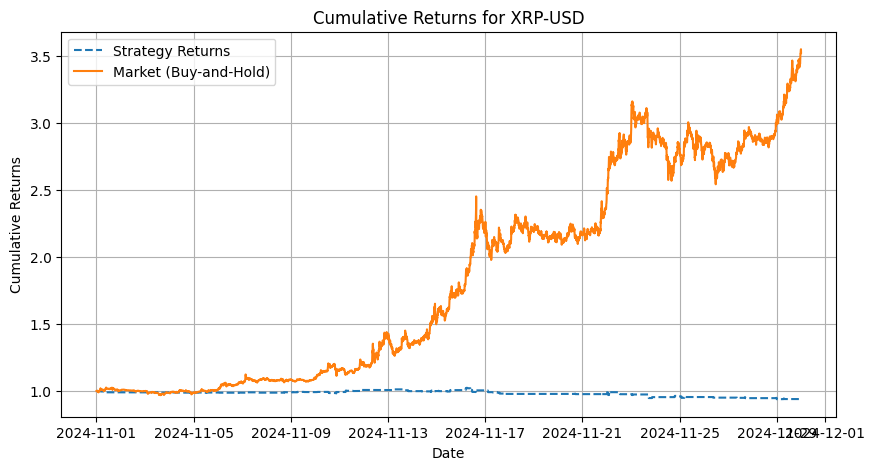

Processing 8351 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8351,)


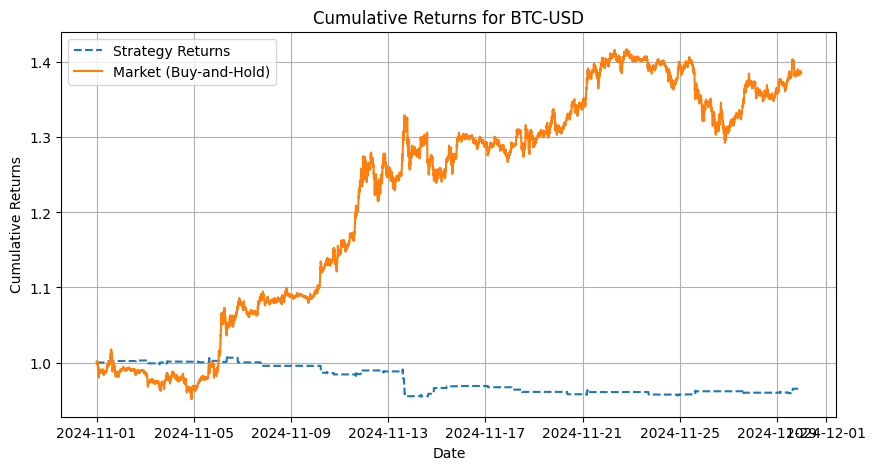

Processing 8349 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8349,)


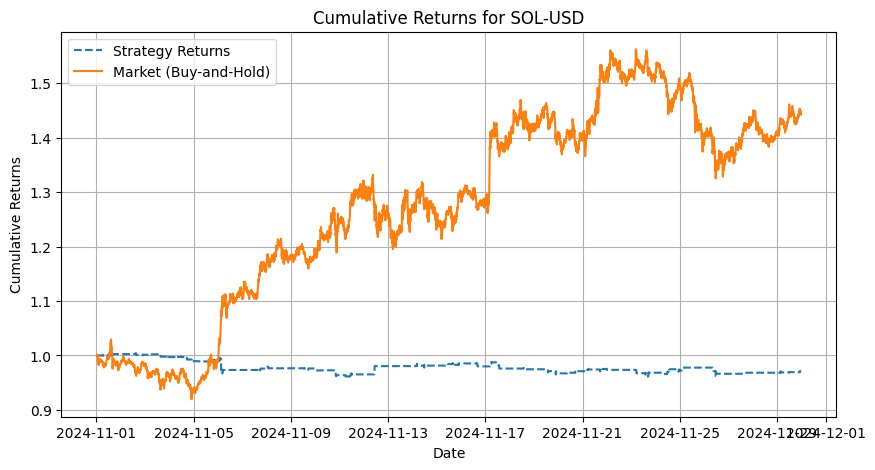

Processing 8351 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8351,)


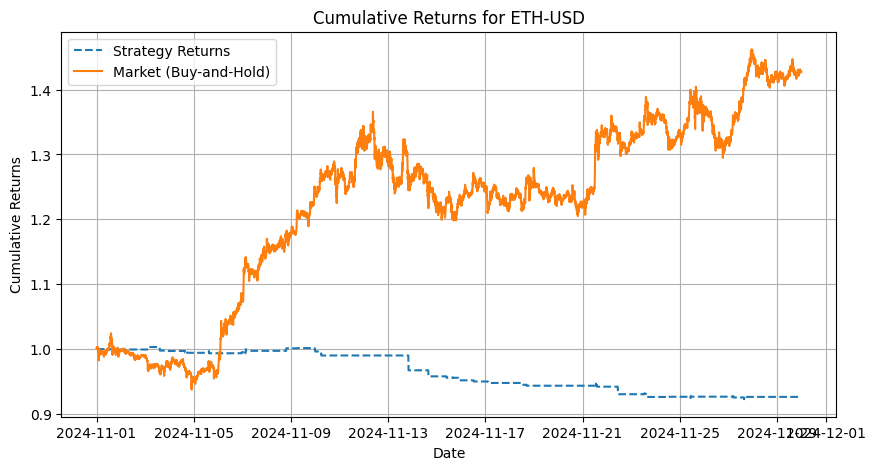

Processing 8351 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8351,)


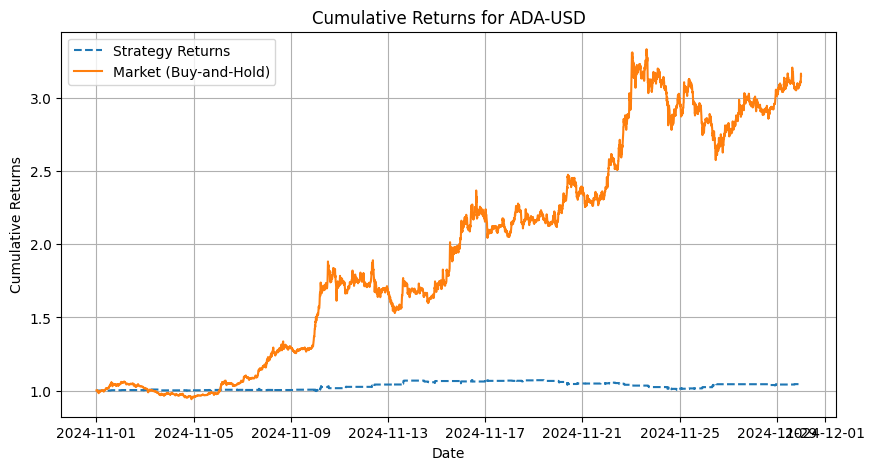

Processing 8349 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8349,)


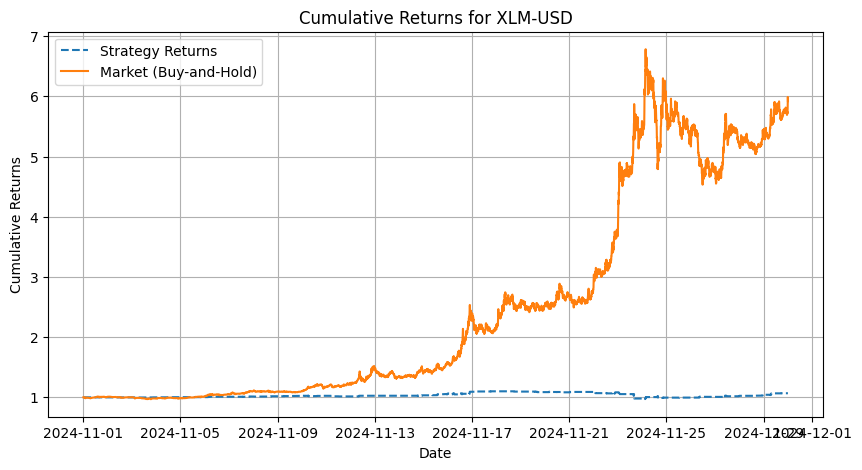

Processing 8330 rows for data: Close column type <class 'pandas.core.series.Series'>, shape (8330,)


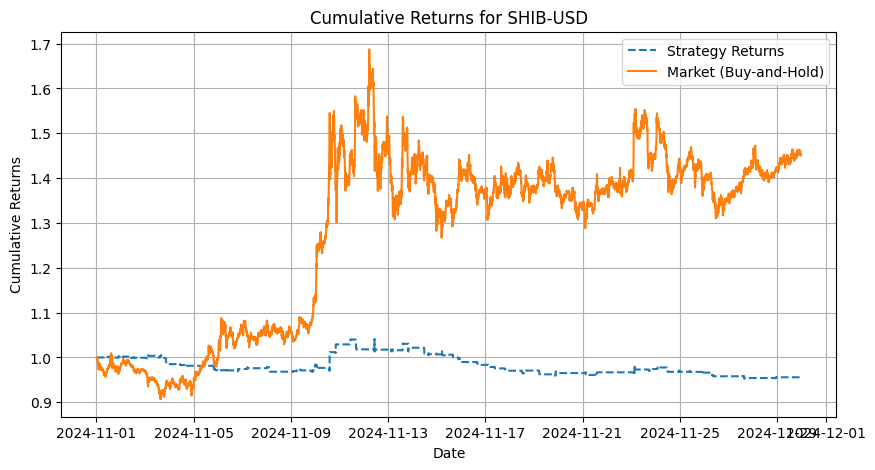

IndexError: single positional indexer is out-of-bounds

In [5]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import yfinance as yf

def apply_rsi_macd_strategy(df):
    # Check if the Close column exists and is properly structured
    if 'Close' not in df.columns:
        raise KeyError("The dataframe does not contain a 'Close' column.")

    # Extract Close column and ensure it is a Series
    close = df['Close']
    if not isinstance(close, pd.Series):
        close = close.squeeze()  # Convert to Series if needed

    # Ensure Close is numeric
    close = pd.to_numeric(close, errors='coerce').dropna()
    df = df.loc[close.index]  # Keep rows corresponding to valid Close values

    # Replace the Close column with the cleaned data
    df['Close'] = close

    # Debugging: Check type and structure
    print(f"Processing {len(close)} rows for data: Close column type {type(close)}, shape {close.shape}")

    # Calculate RSI
    df['rsi'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

    # Calculate MACD
    macd = ta.trend.MACD(close=close, window_slow=9, window_fast=6, window_sign=5)
    df['macd_line'] = macd.macd()
    df['signal_line'] = macd.macd_signal()

    # Generate signals
    df['signal'] = 0
    df['signal'] = np.where(
        (df['rsi'] < 30) & (df['macd_line'] > df['signal_line']), 1,  # Buy
        np.where((df['rsi'] > 70) & (df['macd_line'] < df['signal_line']), -1, 0)  # Sell
    )
    df['position'] = df['signal'].diff()

    return df

# Download historical data for cryptocurrencies
tickers = ["DOGE-USD", "PEPE-USD", "XRP-USD", "BTC-USD", "SOL-USD", "ETH-USD", "ADA-USD", "XLM-USD", "SHIB-USD"]
data = {ticker: yf.download(ticker, start="2024-11-01", end="2024-11-30",interval='5m') for ticker in tickers}

# Backtest strategy and compare to market performance
results = {}

for ticker, df in data.items():
    df = apply_rsi_macd_strategy(df)
    
    # Calculate strategy returns
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df['returns'] * df['position'].shift(1)
    df['strategy_cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

    # Calculate buy-and-hold returns
    df['market_cumulative_returns'] = (1 + df['returns']).cumprod()

    # Store results
    results[ticker] = df

    # Plot cumulative returns for strategy vs. market
    plt.figure(figsize=(10, 5))
    plt.plot(df['strategy_cumulative_returns'], label='Strategy Returns', linestyle='--')
    plt.plot(df['market_cumulative_returns'], label='Market (Buy-and-Hold)', linestyle='-')
    plt.title(f'Cumulative Returns for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()

# Summarize performance for each ticker
performance_summary = []

for ticker, df in results.items():
    strategy_final = df['strategy_cumulative_returns'].iloc[-1]
    market_final = df['market_cumulative_returns'].iloc[-1]
    performance_summary.append({
        "Ticker": ticker,
        "Strategy Returns (%)": (strategy_final - 1) * 100,
        "Market Returns (%)": (market_final - 1) * 100,
        "Outperformance (%)": (strategy_final - market_final) * 100
    })

# Convert to DataFrame and display summary
performance_summary_df = pd.DataFrame(performance_summary).sort_values(by="Outperformance (%)", ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(performance_summary_df)